In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [2]:
log_dir = "./logs/online_cascade_general/imdb/"

In [3]:
# get all .log files in the directory
files = [f for f in os.listdir(log_dir) if f.endswith('.log')]
files.sort()
# divide the files into different cascade sizes
cascades = {}
for f in files:
    cascade_size = f.split('_')
    if '_'.join(cascade_size[0:-1]) not in cascades:
        cascades['_'.join(cascade_size[0:-1])] = []
    cascades['_'.join(cascade_size[0:-1])].append(f)

In [4]:
def plot_figure(cascade_logs, cascade_costs):
    cascade_size = len(cascade_logs[0].split('_')) - 1
    print("cascade size: ", cascade_size)
    costs = []
    accus = []
    # plot the data
    for f in cascade_logs:
        # read last line of the file
        with open(log_dir + f, 'r') as file:
            last_line = file.readlines()[-2]
        # data format: '''m1_prediction, m2_prediction, ..., llm_prediction, ground_truth, m1_proportion, m2_proportion, ..., m1_defer_prob, m2_defer_prob, ..., m1_score, m2_score, ..., m1_accuracy, m2_accuracy, llm_accuracy, overall_accuracy'''
        data = re.split(',', last_line.strip())
        model_prop = []
        for k in range(cascade_size):
            model_prop.append(float(data[k + cascade_size + 2]))
        llm_cost = 1 - sum(model_prop)
        model_accu = []
        for k in range(cascade_size):
            model_accu.append(float(data[k + cascade_size * 4 + 2]))
        llm_accuracy = float(data[k + cascade_size * 4 + 3])
        overall_accuracy = float(data[k + cascade_size * 4 + 4])

        # plt.plot(llm_cost, overall_accuracy, '.')
        # plt.annotate(f.split('_')[-1], (llm_cost, overall_accuracy))
        costs.append(llm_cost)
        accus.append(overall_accuracy)

    # sort the data then plot
    costs = np.array(costs)
    accus = np.array(accus)
    idx = np.argsort(costs)
    costs = costs[idx]
    accus = accus[idx]
    plt.plot(costs, accus)

    # plot the baseline point
    # plt.plot(0, 0.853, '^')
    # plt.annotate('LR', (0, 0.853))
    # plt.plot(1, 0.8918, '^')
    # plt.annotate('BERT', (1, 0.8918))
    # draw a line between the two points
    # plt.plot([0, 1], [0.853, 0.8918], '--')
    # draw a line between (1, 0.8918) and (63, 1)
    # plt.plot([1, 63], [0.8918, 1], '--')

    plt.xlabel('total cost')
    plt.ylabel('overall accuracy')
    # set y axis range
    # plt.ylim(0.8, 0.93)
    # plt.xlim(-0.1, 2.5)
    plt.show()

cascade size:  2


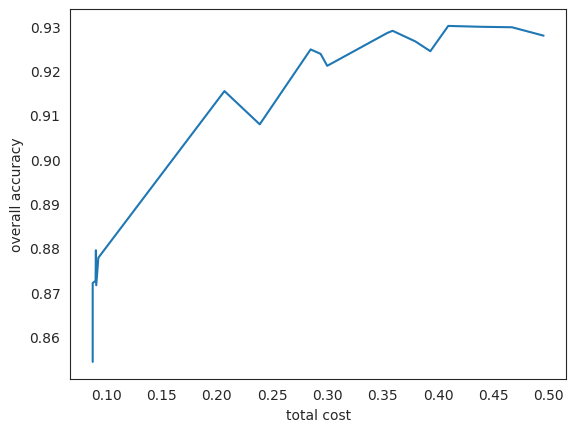

In [9]:
cascade_name = 'LR_BERT-base'
cascade_logs = cascades[cascade_name]
cascade_costs = [1, 1182]

plot_figure(cascade_logs, cascade_costs)

cascade size:  3


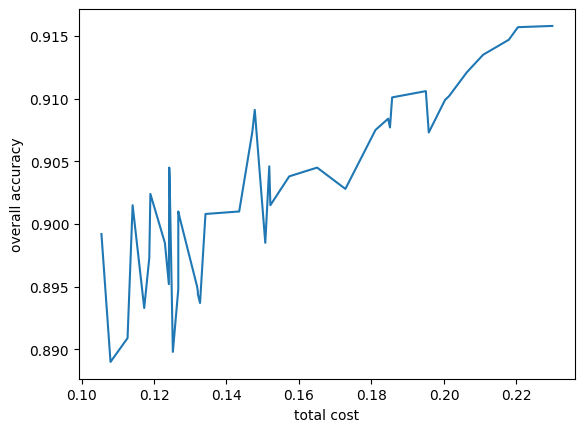

In [6]:
cascade_name = 'LR_BERT-base_BERT-large'
cascade_logs = cascades[cascade_name]
cascade_costs = [1, 3, 382]

plot_figure(cascade_logs, cascade_costs)

/tmp/ipykernel_3036017/1807531764.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])


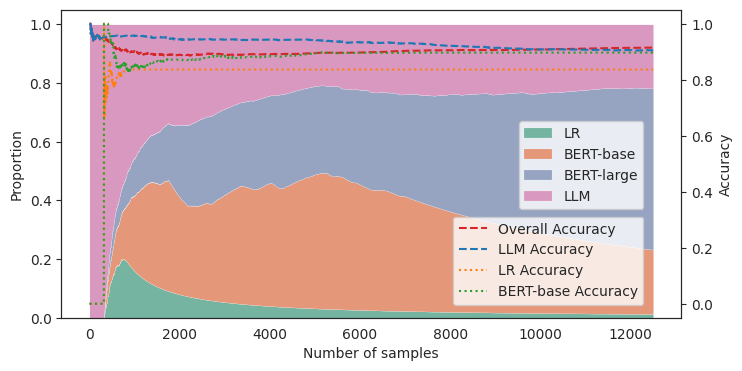

In [21]:
import seaborn as sns
# set seaborn style as whitegrid
sns.set_style("white")
colors = sns.color_palette("Set2", desat=.7)
colors2 = sns.color_palette()
log_name = 'LR_BERT-base_BERT-large_0.000002.log'

cascade_size = len(f.split('_')) - 1
model_prop = [[] for i in range(cascade_size)]
llm_prop = []
model_accu = [[] for i in range(cascade_size)]
model_de_facto_accu = [[] for i in range(cascade_size)]
llm_acc, overall_acc = [], []
with open(log_dir + log_name) as file:
    for line in file.readlines():
        line = line.replace('na', '0')
        data = line.strip().split(',')
        for k in range(cascade_size):
            model_prop[k].append(float(data[k + cascade_size + 2]))
        llm_prop.append(1 - sum(model_prop[i][-1] for i in range(cascade_size)))
        for k in range(cascade_size):
            model_de_facto_accu[k].append(float(data[k + cascade_size * 3 + 2]))
        for k in range(cascade_size):
            model_accu[k].append(float(data[k + cascade_size * 4 + 2]))
        llm_acc.append(float(data[k + cascade_size * 4 + 3]))
        overall_acc.append(float(data[k + cascade_size * 4 + 4]))
    
# plot the proportion on a stacked plot
fig, ax1 = plt.subplots()
ax1.stackplot(range(len(overall_acc)), model_prop, llm_prop, labels=log_name.split('_')[:-1] + ["LLM"], colors=colors, edgecolor='white', linewidth=0.1)
# set a color less transparent
ax1.set_xlabel('Number of samples')
ax1.set_ylabel('Proportion')
ax1.legend(loc='lower right', framealpha=.8,  bbox_to_anchor=(0.95, 0.33))

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')

ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])
ax2.plot(llm_acc, '--', label='LLM Accuracy', color=colors2[0])

for idx, label in enumerate(cascade_name.split('_')):
    ax2.plot(model_de_facto_accu[idx], ':', label=label + ' Accuracy', color=colors2[idx+1])

ax2.legend(loc='lower right', framealpha=.8, bbox_to_anchor=(0.95, 0.02))

fig.set_size_inches(8, 4)
plt.show()
# save as pdf
# fig.savefig('imdb_0.002.pdf', dpi=300, bbox_inches='tight')